In [1]:
# Import required packages and modules
#============================================================================================================================#

import os
import re
import sys
import glob
import numpy as np
import pandas as pd
from pyraf import iraf
from astropy.io import fits
import matplotlib.pyplot as plt
import specutils.io.read_fits as spec
from matplotlib.ticker import MultipleLocator
from astropy.convolution import convolve, Gaussian1DKernel, Box1DKernel

#============================================================================================================================#

In [12]:
#============================================================================================================================#

#Obseravtory site details

OBS_NAME = 'Indian Astronomical Observatory'
OBS_LOCATION = 'Hanle'
OBS_LAT = '32:46:46'
OBS_LON = '78:57:51'
OBS_ALT = 4500
OBS_TIMEZONE = +5.5

#============================================================================================================================#

# New CCD Specification

read_noise_new = 5.75
ccd_gain_new = 0.28
data_max_new = 700000

# Old CCD Specification

read_noise_old = 4.87
ccd_gain_old = 1.22
data_max_old = 55000

#============================================================================================================================#

# Specification of the object under study

OBJECT_NAME = 'SN 2020sck'
OBJECT_RA = '01:10:34.841'
OBJECT_DEC = '+02:06:50.15'
TYPE = 'Iax'
REDSHIFT = 0.0162
EB_V = 0.0256
DM = 34.24
DM_err = 0.22

epoch = 2400000.5
B_band_maximum =  2459098.84

#============================================================================================================================#

# Header keywords

RA_key = 'RA'
DEC_key = 'DEC'
UT_key = 'UT'
DATE_key = 'DATE-AVG'
FILTER_key = 'FILTER'
AIRMASS_key = 'AIRMASS'
EXPTIME_key = 'EXPTIME'
JD_keyword = 'JD'


#============================================================================================================================#

# Spectra directory

Spec_dir = "/home/anirban/2020sck_Reduced/Spectroscopy_20210721/galaxy_lines_removed/"
#synow_dir = '/home/anirban.dutta/2020sck_Reduced/Spectra/Synthetic_spectra/synow_fit/'

os.chdir(Spec_dir)

#============================================================================================================================#

In [3]:
#============================================================================================================================#
# Code that contains all the imporant functions


def remove_file(file_name):
    """
    Removes the file 'file_name' in the constituent directory.
    Args:
         file_name  : Name of the file to be removed from the current directory
    Returns:
        None
    """
    try:
        os.remove(file_name)
    except OSError:
        pass

def remove_similar_files(common_text):
    """
    Removes similar files based on the string 'common_text'.
    Args:
        common_text : String containing partial name of the files to be deleted
    Returns:
        None
    """
    for residual_file in glob.glob(common_text):
        remove_file(residual_file)

#============================================================================================================================#

def group_similar_files(text_list, common_text, exceptions=''):
    """
    Groups similar files based on the string 'common_text'. Writes the similar files
    onto the list 'text_list' (only if this string is not empty) and appends the similar
    files to a list 'python_list'.
    Args:
        text_list   : Name of the output text file with names grouped based on the 'common_text'
        common_text : String containing partial name of the files to be grouped
        exceptions  : String containing the partial name of the files that need to be excluded
    Returns:
        list_files  : Python list containing the names of the grouped files
    """
    list_files = glob.glob(common_text)
    if exceptions != '':
        list_exception = exceptions.split(',')
        for file_name in glob.glob(common_text):
            for text in list_exception:
                test = re.search(text, file_name)
                if test:
                    try:
                        list_files.remove(file_name)
                    except ValueError:
                        pass

    list_files.sort()
    if len(text_list) != 0:
        with open(text_list, 'w') as f:
            for file_name in list_files:
                f.write(file_name + '\n')

    return list_files

#============================================================================================================================#

def text_list_to_python_list(text_list):
    """
    Returns data in the file 'text_list' as a python_list.
    Args:
        text_list   : Input file containing filenames
    Returns:
        python_list : List of all the elements in the file 'text_list'
    Raises:
        Error : File 'text_list 'Not Found
    """
    if os.path.isfile(text_list):
        with open(text_list, 'r+') as f:
            python_list = f.read().split()
            return python_list
    else:
        print ("Error : File '{0}' Not Found".format(text_list))
        sys.exit(1)


def python_list_to_text_list(python_list, text_list):
    """
    Put the data from the input 'python_list' to a file 'text_list' line-wise.
    Args:
        python_list : Python_list from which data has to be read
        text_list   : Name of the text file onto which data has to be appended
    Returns:
        None
    """
    with open(text_list, 'w') as f:
        for element in python_list:
            f.write(element + '\n')
            
            
#============================================================================================================================#

def convert_date_to_jd(time):
    
    '''
    Function to convert date in fits format to JD.
    time: Date in Fits format (e.g. 2021-03-31T03:03:20.50)
    
    Returns: jd, mjd
    
    '''
    from astropy.time import Time
    
    t = Time(time, format='isot', scale='utc')
    jd = t.jd
    mjd = t.mjd
    
    return jd


def convert_jd_to_date(jd):
    
    '''
    Function to convert JD to calender date
    jd: Julian Date
    
    e.g. jd=2459086.93
    
    Returns: date in utc
    '''
    from astropy.time import Time
    
    t = Time(jd, format='jd', scale='utc')
    date = t.iso
    
    return date

#============================================================================================================================#

def read_date(file_name):
    
    """
    Reads JD of observation of the file "file_name".
    Args:
        file_name   : Name of the 1-D Spectra whose JD of observation is to be found out
    Returns:
        julian_day  : Julian day of the 1-D spectra
    """
    
    calender_date = fits.getval(filename=file_name, keyword=DATE_key)
    jd = convert_date_to_jd(calender_date)
    

    return jd

#============================================================================================================================#

def read_1dspec(file_name):
    
    """
    Reads 1-D Spectra from a FITS file and returns wavelength and flux arrays.
    Args:
        file_name    : FITS file from which data has to be extracted
    Returns:
        wave_array   : Array containing wavelength values extracted from the 1-D Spectra
        flux_array   : Array containing flux values extracted from the 1-D Spectra
    """
    
    with fits.open(file_name) as hdulist:
        axis = int(hdulist[0].header['NAXIS'])
        if axis == 1:
            flux_array = hdulist[0].data
            wave_array = spec.read_fits_spectrum1d(file_name).dispersion
        else:
            flux_array = hdulist[0].data[0][0]
            wave_array = spec.read_fits_spectrum1d(file_name)[0].dispersion
    
    return wave_array, flux_array

#============================================================================================================================#


def write_1dspec(ref_filename, flux_array, prefix_str):
    
    """
    Writes 1-D Spectra onto a FITS file.
    Args:
        ref_filename : FITS file from which header has to be extracted
        flux_array   : Array containing flux values
        prefix_str   : Prefix to distinguish the smoothened 1-D spectra from the original
    Returns:
        None
    """
    
    with fits.open(ref_filename) as hdulist:
        file_header = hdulist[0].header
        
    output_filename = prefix_str + ref_filename
    remove_file(output_filename)
    fits.writeto(output_filename, data = flux_array, header = file_header)
        
#============================================================================================================================#

def smooth_1dspec(common_text, sp = 20, kernel = 'gaussian', prefix_str = 'z_', plot = False):
    
    """
    Smoothens a 1-D spectra based on the smoothening parameter. Smoothening parameter
    is 'std.dev.' in case of isotropic Gaussian filter and is 'width' in the case of the
    non-isotropic box filter.
    Args:
        common_text : Common text of 1-D spectra files which have to be smoothened
        sp          : Smoothening parameter
        kernel      : Convolution Kernel used for smoothening (Gaussian or Box)
        prefix_str  : Prefix to distinguish the smoothened 1-D spectra from the original
        plot        : Boolean describing whether the smoothened spectra has to be plotted
    Returns:
        None
    """
    for text in ['z_*.dat']:
        remove_similar_files(text)
    
    list_spectra = group_similar_files('', common_text = common_text)
    usable_kernel = Gaussian1DKernel(int(sp), mode='oversample')
    
    if kernel.lower() != 'gaussian':
        if kernel.lower == 'box':
            usable_kernel = Box1DKernel(int(sp))
        else:
            print ("Error: Kernel '{0}' Not Recognised".format(kernel))
            sys.exit(1)
            
    for file_name in list_spectra:
        #wave_data, flux_data = read_1dspec(file_name)
        #smoothed_data = convolve(flux_data, usable_kernel)
        #write_1dspec(ref_filename = file_name, flux_array = smoothed_data, prefix_str = prefix_str)
        columns = ['Wave', 'Flux']
        unsmoothed_df = pd.read_csv(file_name, sep='\s+', names=columns, engine='python')
        #print (type(unsmoothed_df['Flux'].values))
        smoothed_flux = convolve(unsmoothed_df['Flux'].values, usable_kernel)
        wave_array = unsmoothed_df['Wave'].values
        unsmoothed_flux = unsmoothed_df['Flux'].values
        smoothed_df = pd.DataFrame(list(zip(wave_array, smoothed_flux)), columns=['Wavelength', 'Flux'])
        smoothed_flux = smoothed_df['Flux'].values
        smoothed_df.to_csv(prefix_str+file_name, sep=' ', index=None, header=['Wavelength', 'Flux'])
        
        if plot:
            plt.figure(figsize=(6,6))
            plt.plot(wave_array, unsmoothed_flux, 'g', label = 'Original Spectrum')
            plt.plot(wave_array, smoothed_flux, 'r--', label = 'Smooth Spectrum', alpha=0.5)
            plt.legend()
            plt.show()
            plt.close()

#============================================================================================================================#

def wspectext(common_text, out_ext = '.dat'):
    
    """
    Converts a list of 1-D spectra FITS files into a two-column text file.
    Args:
        common_text      : Common text of 1-D spectra FITS files
        out_ext          : Name of the extension to be used for the output file
    Returns:
        list_outspectra  : Python list of 1-D spectra DAT files
    """
    list_spectra = group_similar_files('', common_text = common_text)
    
    task = iraf.noao.onedspec.wspectext
    task.unlearn()
    
    list_outspectra = []
    for spectrum in list_spectra:
        output_spectrum = spectrum.split('.')[0] + out_ext
        task(input = spectrum[1], output = output_spectrum, header = 'no')
        list_outspectra.append(output_spectrum)
        
    return list_outspectra

#============================================================================================================================#


def convert_to_text(common_text, out_ext = '.dat'):
    
    """
    Converts a list of 1-D spectra FITS files into a two-column text file.
    Args:
        common_text      : Common text of 1-D spectra FITS files
        out_ext          : Name of the extension to be used for the output file
    Returns:
        list_outspectra  : Python list of 1-D spectra DAT files
    """
    
    list_spectra = group_similar_files('', common_text = common_text)
    
    list_outspectra = []
    for spectrum in list_spectra:
        wave_array, flux_array = read_1dspec(spectrum)
        spec_df = pd.DataFrame(flux_array, index = wave_array)
        output_spectrum = spectrum.split('.')[0] + out_ext
        spec_df.to_csv(output_spectrum, sep = ' ', index = True, header = None)
        list_outspectra.append(output_spectrum)
        
    return list_outspectra

#============================================================================================================================#

def calculate_dist(dist_mod, dist_modd_err):
    
    d = (10**((dist_mod+5)/5))/10**6
    d_err = (2.303 * d * dist_modd_err)/5
    
    return d, d_err


def cal_lum(flux, name):
    
    if name != '':
        dist = pd.to_numeric(SNdata_df.loc[name, 'Distance'])  # in Mpc
        dist_err = pd.to_numeric(SNdata_df.loc[name, 'Distance_err']) # in Mpc
        
    else:
        dist = calculate_dist(DM, DM_err)[0]
        dist_err = calculate_dist(DM, DM_err)[1]
        
    """
    For a star(object) with known distance and measured flux, the luminosity is:

    L=flux*4*pi*D^2 
    
    1 parsec = 3.26 ly 
    1 ly = 9.461e17 cm
    1 parsec = 3.086e18 cm

    """
    
    ##---------- Luminosity ----------##
    val_lum = float(flux) * 4 * np.pi * (3.086e24)**2
    luminosity = (val_lum)*dist**2
    luminosity_err = (8*np.pi*flux) * (dist) * (dist_err) * (3.086e24)**2
    ##--------------------------------------##
    
    return float(luminosity), float(luminosity_err) 

#============================================================================================================================#

def deredden(common_text, prefix_str = 'd', redden = EB_V):
    
    '''Corrects a list of spectra for reddening'''
    
    list_spectra = group_similar_files('', common_text = common_text)
    
    task = iraf.noao.onedspec.deredden
    task.unlearn()
        
    task.R = 3.1
    task.type = 'E(B-V)'
    
    list_outspectra = []
    for spectrum in list_spectra:
        output_spectrum = prefix_str + spectrum
        task(input = spectrum, output = output_spectrum, value = redden)
        list_outspectra.append(output_spectrum)
        
    return list_outspectra

#============================================================================================================================#

def sort_list(input_list, smooth = False):
    
    import datetime

    dates = []
    
    if smooth:
        for filename in input_list:
            if 'z_drtf' in filename:
                date = filename[6:16]
            else:
                date = filename[4:14]
            dates.append(date)
    else:
        
        for filename in input_list:
            if 'rts' in filename:
                date = filename[3:13]
            else:
                date = filename[2:12]
            dates.append(date)
    
        
    
    output_list = []
    sorted_dates = sorted(dates, key=lambda x: datetime.datetime.strptime(x, '%Y-%m-%d'))
    for date in sorted_dates:
        for filename in input_list:
            if date in filename:
                output_list.append(filename)
                
    return output_list
            
#============================================================================================================================#    

In [13]:
list_spec = group_similar_files('', common_text='rgts*.fits')
print (list_spec)

['rgts2020-08-31_SN2020sck.fits', 'rgts2020-09-01_SN2020sck.fits', 'rgts2020-09-07_SN2020sck.fits', 'rgts2020-09-08_SN2020sck.fits', 'rgts2020-09-11_SN2020sck.fits', 'rgts2020-09-13_SN2020sck.fits', 'rgts2020-09-16_SN2020sck.fits', 'rgts2020-09-20-SN2020sck.fits', 'rgts2020-09-24_SN2020sck.fits', 'rgts2020-09-27_SN2020sck.fits', 'rgts2020-09-29_SN2020sck.fits', 'rgts2020-10-03_SN2020sck.fits', 'rgts2021-01-11_SN2020sck.fits']


In [5]:
#rmv_files = True
#ctext = 'f*.fits'
#bool_smooth = True
#clip_str = '3500:9100'

#if rmv_files:
#    for text in ['drts*.fits']:
        
#        remove_similar_files(common_text=text)
        
#dered_list_spec = deredden(common_text = 'rts*.fits')

In [14]:
#rm_files = 'z_*.dat'

for text in ['z_*.dat']:
    remove_similar_files(common_text=text)
    
smooth_1dspec(common_text = 'drgts*.dat', sp = 2.0, kernel = 'gaussian', prefix_str = 'z_', plot = False)
list_textspec_smooth = group_similar_files('', common_text='z_*.dat')
print (list_textspec_smooth)

#ctext = 'drts*.fits'
#smooth_1dspec(common_text = 'drf*.dat', sp = 1.5, kernel = 'gaussian', prefix_str = 'z_', plot = False)
#list_textspec = convert_to_text(ctext)
#list_textspec = group_similar_files('', common_text='drts*.dat')

#print (list_textspec)

#print list_textspec_sorted    
        
#print list_textspec
#print list_textspec_smooth
#output_list = sort_list(list_spec)
#spec_df_sm = pd.DataFrame(output_list, columns = ['FileName'])
#spec_df_sm['TextFile'] = sort_list(list_textspec_smooth, smooth = True)
#spec_df_sm['Epoch'] = spec_df_sm['FileName'].apply(lambda z: read_jd(z)-2458000)
#spec_df_sm['Phase'] = spec_df_sm['FileName'].apply(lambda x: read_jd(x) - B_band_maximum)
#spec_df_sm['Label'] = spec_df_sm['Phase'].apply(lambda x: '+{0:>.1f} d'.format(x) if x > 0 else '{0:>.2f} d'.format(x))
#spe_df_sm = spec_df_sm.sort_values(by = 'Phase').reset_index(drop = True)
#spec_df_sm = spec_df_sm.set_index('FileName')  
#print ("--------Smoothed Dataframe--------")
#print (spec_df_sm)
#print ("-----------------------------------")
    



['z_drgts2020-08-31_SN2020sck.dat', 'z_drgts2020-09-01_SN2020sck.dat', 'z_drgts2020-09-07_SN2020sck.dat', 'z_drgts2020-09-08_SN2020sck.dat', 'z_drgts2020-09-11_SN2020sck.dat', 'z_drgts2020-09-13_SN2020sck.dat', 'z_drgts2020-09-16_SN2020sck.dat', 'z_drgts2020-09-20-SN2020sck.dat', 'z_drgts2020-09-24_SN2020sck.dat', 'z_drgts2020-09-27_SN2020sck.dat', 'z_drgts2020-09-29_SN2020sck.dat', 'z_drgts2020-10-03_SN2020sck.dat', 'z_drgts2021-01-11_SN2020sck.dat']


In [15]:
output_list = sort_list(list_spec, smooth=True)
spec_df = pd.DataFrame(output_list, columns = ['FileName'])
spec_df['TextFile'] = list_textspec_smooth
spec_df['Phase'] = spec_df['FileName'].apply(lambda x: read_date(x) - B_band_maximum)
spec_df['Label'] = spec_df['Phase'].apply(lambda x: '+{0:>.1f} d'.format(x) if x > 0 else '{0:>.1f} d'.format(x))
spec_df = spec_df.sort_values(by = 'Phase').reset_index(drop = True)
spec_df = spec_df.set_index('FileName')
print ("--------UnSmoothed Dataframe--------")
print (spec_df)
print ("-----------------------------------")
spec_df = spec_df.reset_index()
spec_df = spec_df[spec_df['Phase'] < 100].copy()
#print (Premaxima_df)

--------UnSmoothed Dataframe--------
                                                      TextFile       Phase  \
FileName                                                                     
rgts2020-08-31_SN2020sck.fits  z_drgts2020-08-31_SN2020sck.dat   -5.527905   
rgts2020-09-01_SN2020sck.fits  z_drgts2020-09-01_SN2020sck.dat   -4.574579   
rgts2020-09-07_SN2020sck.fits  z_drgts2020-09-07_SN2020sck.dat    1.402475   
rgts2020-09-08_SN2020sck.fits  z_drgts2020-09-08_SN2020sck.dat    2.609420   
rgts2020-09-11_SN2020sck.fits  z_drgts2020-09-11_SN2020sck.dat    5.513195   
rgts2020-09-13_SN2020sck.fits  z_drgts2020-09-13_SN2020sck.dat    7.552932   
rgts2020-09-16_SN2020sck.fits  z_drgts2020-09-16_SN2020sck.dat   10.436109   
rgts2020-09-20-SN2020sck.fits  z_drgts2020-09-20-SN2020sck.dat   14.342396   
rgts2020-09-24_SN2020sck.fits  z_drgts2020-09-24_SN2020sck.dat   18.465080   
rgts2020-09-27_SN2020sck.fits  z_drgts2020-09-27_SN2020sck.dat   21.556097   
rgts2020-09-29_SN2020sck.fi

In [16]:
spec_df_latex = spec_df.copy()
spec_df_latex['Epoch'] = spec_df['FileName'].apply(lambda x: read_date(x))
spec_df_latex['JD'] = spec_df_latex['Epoch'].apply(lambda x: x - 2459000)
spec_df_latex['Date'] = spec_df_latex['Epoch'].apply(lambda x: convert_jd_to_date(x))

get_paper_ready_df = spec_df_latex[['JD', 'Date', 'Phase']]
print get_paper_ready_df
#get_paper_ready_df.to_latex('/home/anirban.dutta/2020sck/Results/Plots/Spectra_log.tex', index=False, float_format='%.2f')

            JD                     Date      Phase
0    93.312095  2020-08-31 19:29:25.038  -5.527905
1    94.265421  2020-09-01 18:22:12.415  -4.574579
2   100.242475  2020-09-07 17:49:09.836   1.402475
3   101.449420  2020-09-08 22:47:09.874   2.609420
4   104.353195  2020-09-11 20:28:36.085   5.513195
5   106.392932  2020-09-13 21:25:49.323   7.552932
6   109.276109  2020-09-16 18:37:35.793  10.436109
7   113.182396  2020-09-20 16:22:39.057  14.342396
8   117.305080  2020-09-24 19:19:18.933  18.465080
9   120.396097  2020-09-27 21:30:22.791  21.556097
10  122.388383  2020-09-29 21:19:16.270  23.548383
11  126.342032  2020-10-03 20:12:31.549  27.502032


In [9]:
# Read Synow dataframe

#synow_spec_1 = synow_dir_1 + 'synow_out.dat'
#synow_spec_2 = synow_dir_2 + 'synow_out.dat'

#col_names = ['Wave', 'Flux', 'FluxErr']

#synow_df_1 = pd.read_csv(synow_spec_1, sep='\s+', names=col_names, engine='python')
#synow_df_2 = pd.read_csv(synow_spec_2, sep='\s+', names=col_names, engine='python')
# Synow files

#list_synow = group_similar_files('', common_text=synow_dir+'synow*')


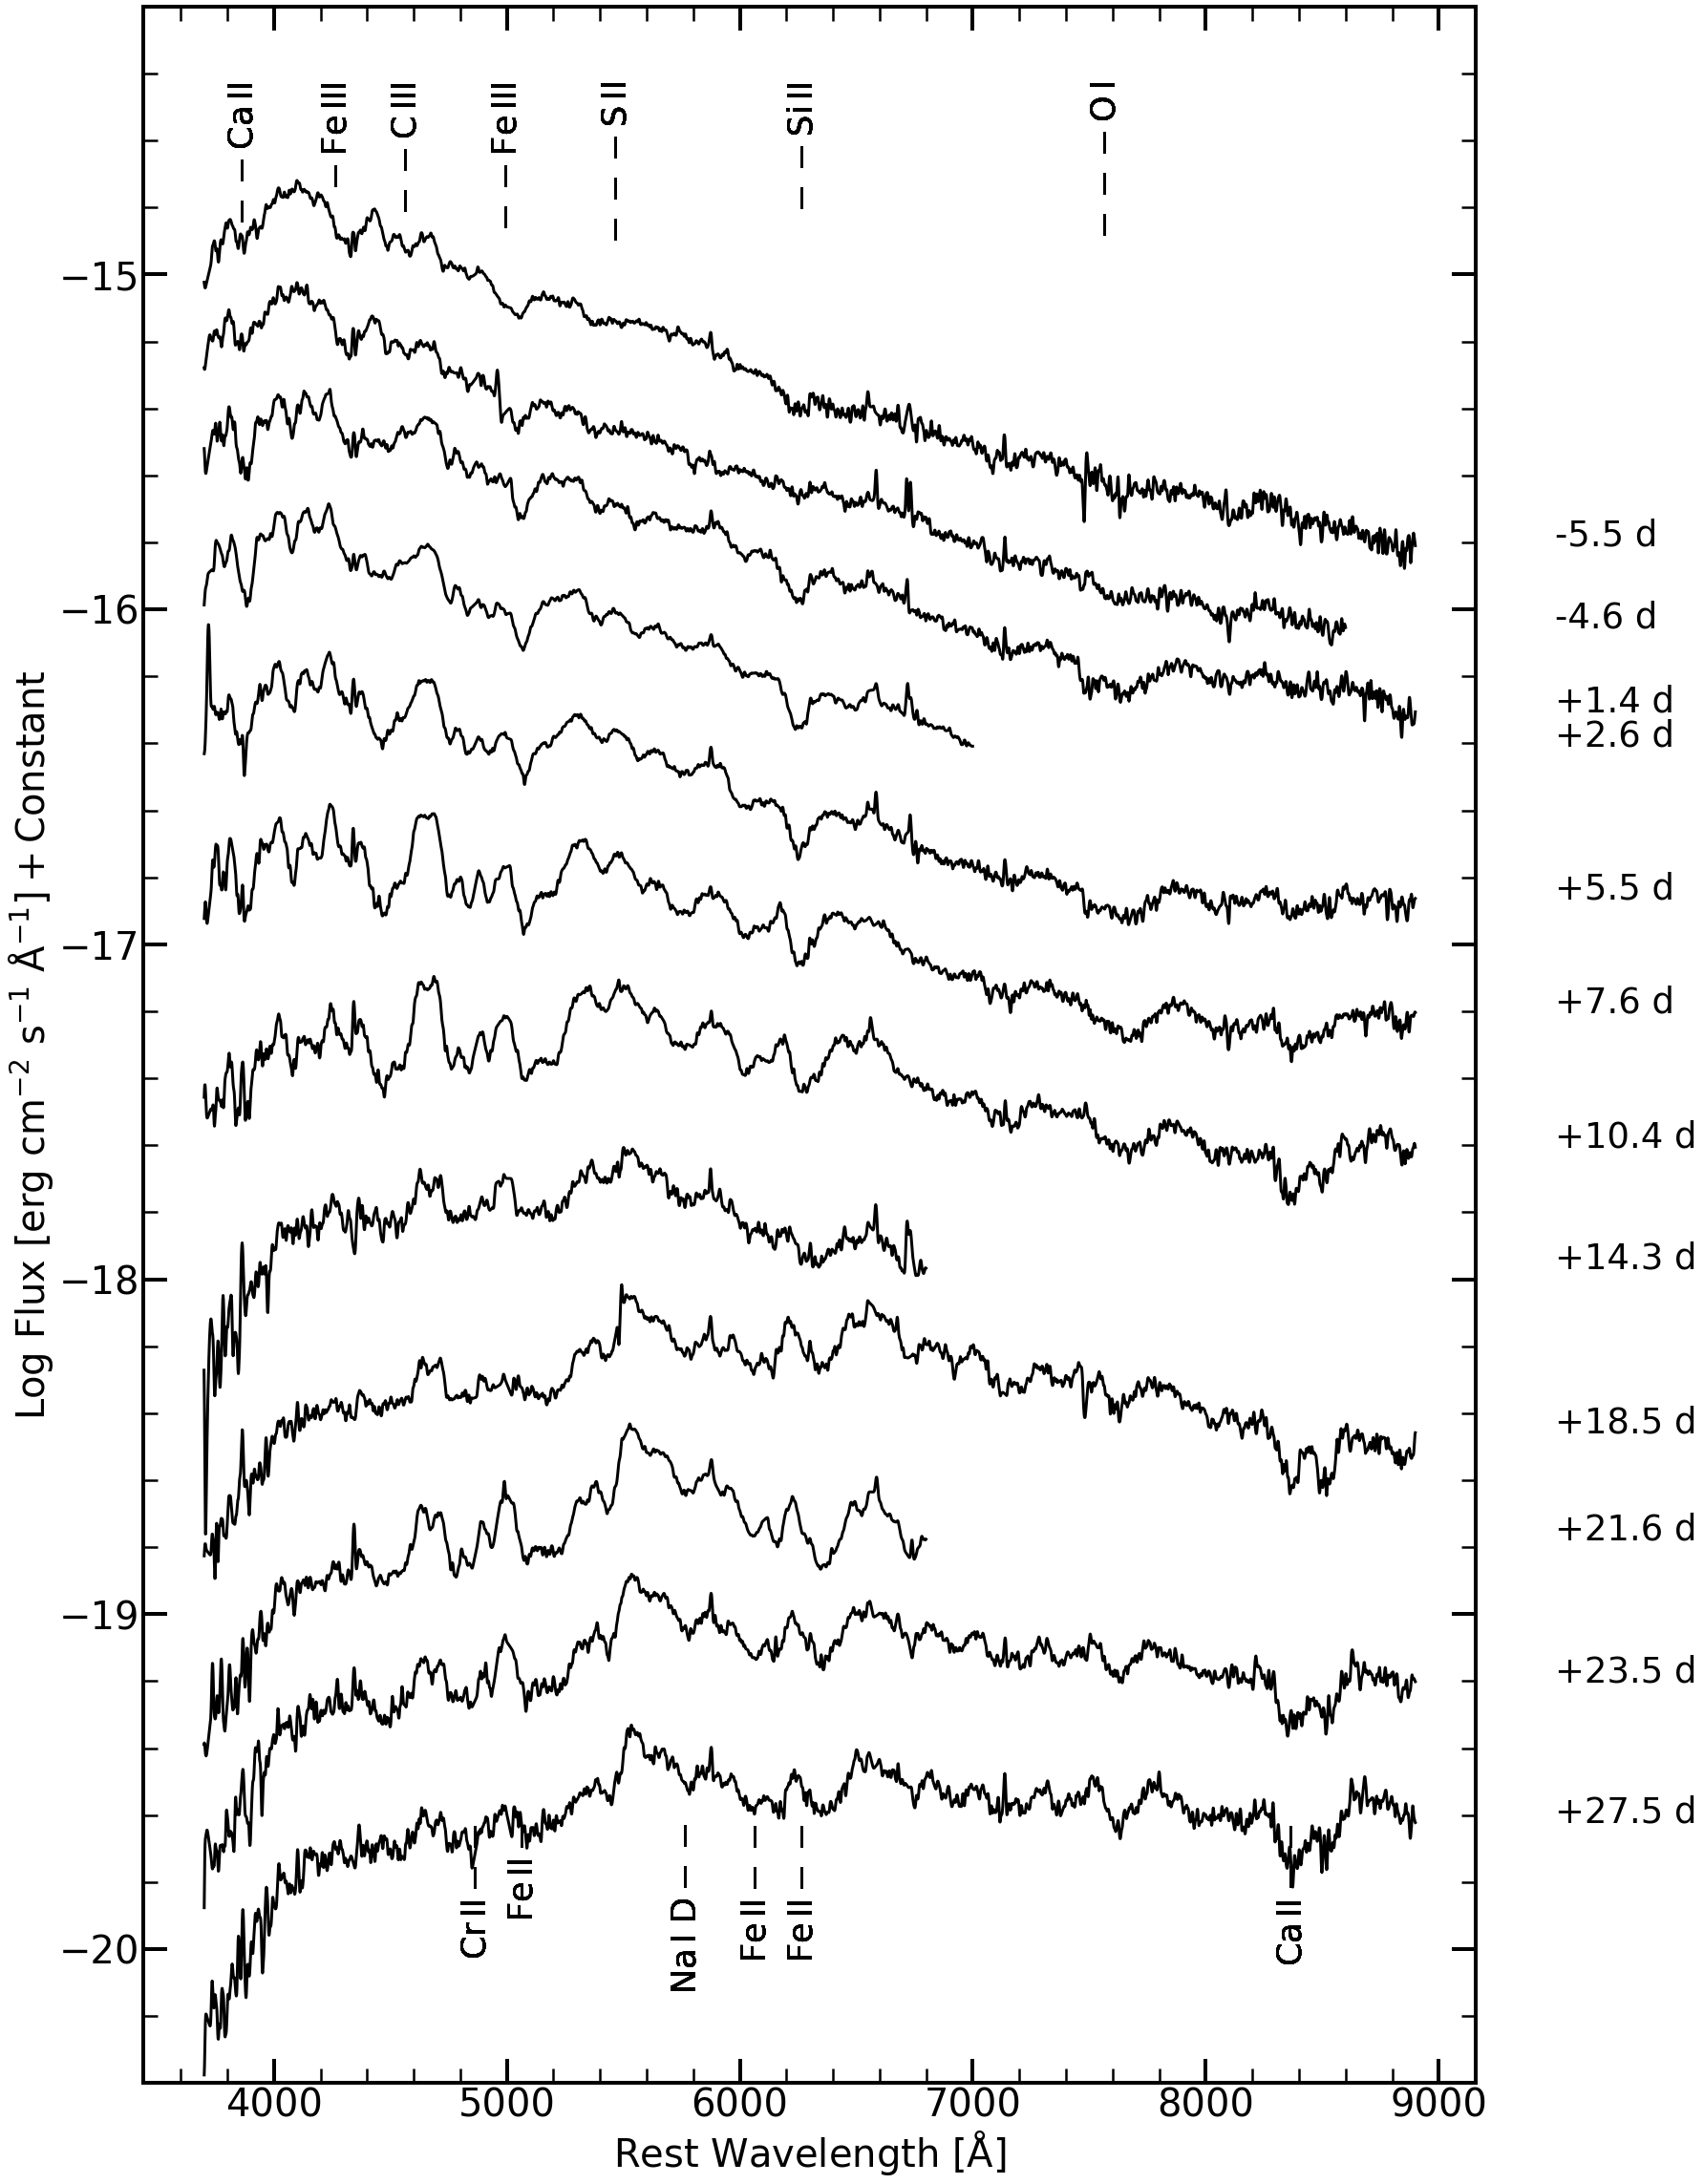

In [23]:
clip_str = '3700:8900'
plt.rcParams['axes.linewidth'] = 4
fig = plt.figure(figsize = (25, 40))
ax = fig.add_subplot(111)

fig.patch.set_facecolor('white')
lower_clip, upper_clip = clip_str.split(':')
col_names = ['Wave', 'Flux', 'FluxErr']
color = ['#ff0000', '#ff8700', '#ff0000', '#ff8700', '#ff0000', '#ff8700',
        '#ff0000', '#ff8700', '#ff0000', '#ff8700', '#ff0000', '#ff8700',
        '#ff0000', '#ff8700']


#axins = zoomed_inset_axes(ax, 5.0, loc='center') # zoom-factor: 2.5, location: upper-left
for index, file_name in spec_df['TextFile'].items():
    

    data_df = pd.read_csv(file_name, sep = '\s+', dtype='float64')
    if index == 3:
        data_df = data_df[(data_df['Wavelength'] >= int(lower_clip)) & (data_df['Wavelength'] <= int(7000))]
    if index == 7 or index == 9:
        data_df = data_df[(data_df['Wavelength'] >= int(lower_clip)) & (data_df['Wavelength'] <= int(6800))]
    elif index == 1:
        data_df = data_df[(data_df['Wavelength'] >= int(lower_clip)) & (data_df['Wavelength'] <= int(8600))]
    else:
        data_df = data_df[(data_df['Wavelength'] >= int(lower_clip)) & (data_df['Wavelength'] <= int(upper_clip))]
        
        
        
    if index != 7:
        #data_df['LogFlux'] = data_df['Flux'].apply(lambda x: np.log10(x) - index*0.4)
        data_df['LogFlux'] = data_df['Flux'].apply(lambda x: np.log10(x) - index*0.35)
    else:
        #data_df['LogFlux'] = data_df['Flux'].apply(lambda x: np.log10(x) - index*0.38)
        data_df['LogFlux'] = data_df['Flux'].apply(lambda x: np.log10(x) - index*0.35)
    #synow_df = pd.read_csv(list_synow[index], sep='\s+', names=col_names, engine='python')
    #synow_df['LogFlux'] = synow_df['Flux'].apply(lambda x: np.log10(x) - index*0.5)
    #synow_df = synow_df[(synow_df['Wave'] >= int(lower_clip)) & (synow_df['Wave'] <= int(upper_clip))]
    #dta_df['Flux'] -= 1.0e-15 * index   ## flux = flux - (1.0e-15*index)
    #if index == 0:
    #if index != 10:
    ax.plot(data_df['Wavelength'], data_df['LogFlux'], label = '_nolegend_', alpha = 1.0,
            color='black', lw=3.0)
    ax.text(x = 9500, y = data_df['LogFlux'].values[-1], 
            s = spec_df.loc[index, 'Label'], fontsize = 37, rotation = 'horizontal')

    #ax.plot(synow_df['Wave'], synow_df['LogFlux'], ls='-', lw='2', color='black')
    
    #ax.text(x = 9500,y = data_df['LogFlux'].values[-10],
    #        s = Premaxima_df.loc[index, 'Label'], fontsize = 25, rotation = 'horizontal')
    
    y = -14.5
    dict_label = {r'$\rm ---S\,II$':[5400, y], 
                     r'$\rm ---O\,I$':[7500, y], 
                      r'$\rm --C\,III$':[4500, y],
                      r'$\rm -Fe\,III$':[4200, y],
                      r'$\rm --Ca\,II$': [3800, y]}

    for (line, [wavelength, width]) in dict_label.items():
        ax.text(wavelength, width, line, fontsize = 35, rotation = 'vertical')   
            
            
    dict_label_1 = {r'$\rm --Si\,II$':[6200, y], r'$\rm --Fe\,III$':[4930, y]}
            
            
    for (line, [wavelength, width]) in dict_label_1.items():
        ax.text(wavelength, width, line, fontsize = 35, rotation = 'vertical')  
        
    y1 = -19.7
    dict_label = {r'$\rm Ca\,II--$': [8300, y1], r'$\rm Fe\,II--$': [6200, y1],
                 r'$\rm Na\,I\ D--$': [5700, y1], r'$\rm Cr\,II--$': [4800, y1]}
    
    for (line, [wavelength, width]) in dict_label.items():
        ax.text(wavelength, width, line, fontsize = 35, rotation = 'vertical')  
        
    y1 = -19.7
    dict_label = {r'$\rm Fe\,II--$': [6000, y1], r'$\rm Fe\,II-$': [5000, y1]}
    
    for (line, [wavelength, width]) in dict_label.items():
        ax.text(wavelength, width, line, fontsize = 35, rotation = 'vertical')   

    
#ax.yaxis.set_major_formatter(plt.NullFormatter()) 
ax.xaxis.set_ticks_position('both')
ax.yaxis.set_ticks_position('both')
ax.xaxis.set_major_locator(MultipleLocator(1000))
ax.xaxis.set_minor_locator(MultipleLocator(200))
ax.yaxis.set_major_locator(MultipleLocator(1))
ax.yaxis.set_minor_locator(MultipleLocator(0.2))

ax.tick_params(axis = 'both', which = 'major', direction = 'in', length = 25, width = 4.0, labelsize = 12)
ax.tick_params(axis = 'both', which = 'minor', direction = 'in', length = 15, width = 2.5, labelsize = 12)

for tick in ax.xaxis.get_major_ticks():
    tick.label1.set_fontsize(fontsize = 40)
    #tick.label1.set_fontweight('bold')
    
for tick in ax.yaxis.get_major_ticks():
    tick.label1.set_fontsize(fontsize = 40)
    
ax.set_ylim(-20.4, -14.2)    
ax.set_xlabel(r'Rest Wavelength [$\rm \AA$]', fontsize=40, fontname = 'Times New Roman')
#ax.set_ylabel(r'Scaled Flux [$\rm erg\ cm^{-2}\ s^{-1}\ \AA^{-1}$] + Constant', fontsize=25, fontname = 'Times New Roman');
ax.set_ylabel(r'$\rm Log\ Flux\ [erg\ cm^{-2}\ s^{-1}\ \AA^{-1}] + Constant$', fontsize=40, fontname = 'Times New Roman');
#ax.set_title("Spectral Evolution of SN2020sck", fontsize = 25, pad = 9, fontname = 'Times New Roman')
plt.savefig("/home/anirban/2020sck/Results/New_Results/Results/Plots/2020sck_Spectra_Collage.png", 
             dpi = 100, bbox_inches='tight')

ValueError: could not convert string to float: Wavelength

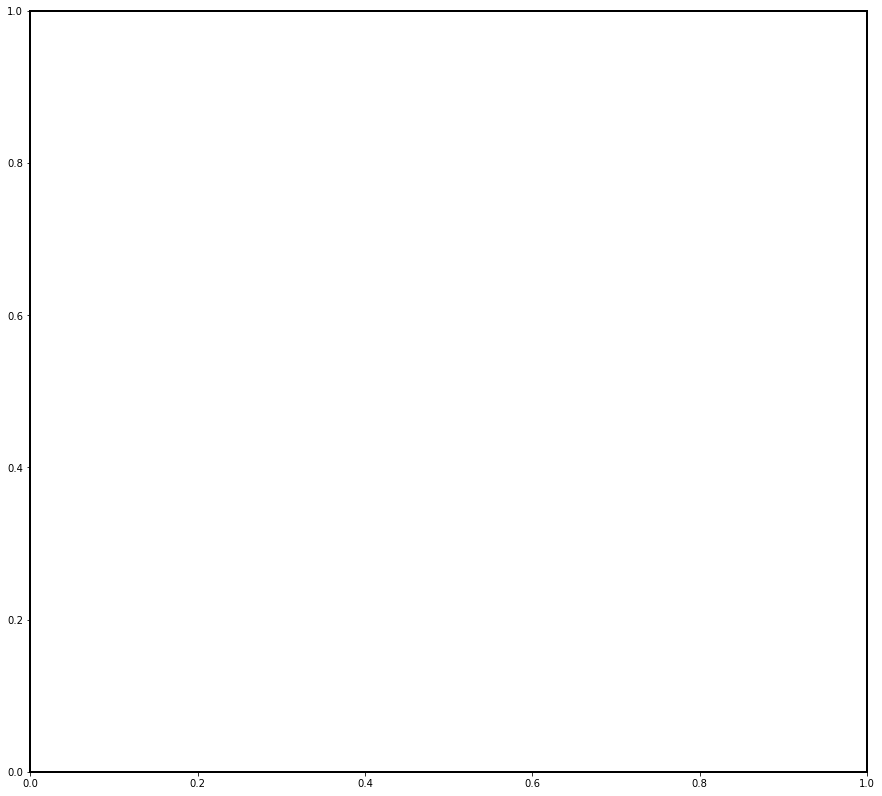

In [11]:
clip_str = '3500:9100'
plt.rcParams['axes.linewidth'] = 2
fig = plt.figure(figsize = (15,14))
ax = fig.add_subplot(111)

fig.patch.set_facecolor('white')
lower_limit, upper_limit = clip_str.split(':')

#color = ['mediumaquamarine', 'thistle', 'lightblue', 'lightsalmon', 'bisque']

#axins = zoomed_inset_axes(ax, 5.0, loc='center') # zoom-factor: 2.5, location: upper-left
for index, file_name in spec_df['TextFile'].items():
    data_df = pd.read_csv(file_name, names = ['Wavelength', 'Flux'], sep = '\s+', dtype = 'float64')
    data_df = data_df[(data_df['Wavelength'] >= int(lower_limit)) & (data_df['Wavelength'] <= int(upper_limit))]
    data_df['LogFlux'] = data_df['Flux'].apply(lambda x: np.log10(x) - index*0.5)
    
    #if file_name == 'r2019-03-04_SN2019np.dat':
    #    data_df['Flux'] -= 1.0e-15 * index   
    #    data_df['Flux'] = data_df['Flux']
    #else:
    data_df['Flux'] -= 1.0e-15 * index   ## flux = flux - (1.0e-15*index)
    if index == 0:
        ax.plot(data_df['Wavelength'], data_df['Flux'], label = '_nolegend_', alpha = 0.9)
        ax.text(x = 9500, y = data_df['Flux'].values[-1], s = spec_df.loc[index, 'Label'], fontsize = 18, rotation = 'horizontal')
    
y = 0.6e-14
dict_label = {r'$\rm Si\ II\ 6355$':[6000, y]}#, r'$\rm C\ II\ 6580$': [6280, y], r'$\rm Ca\ II\ (H&K)$': [3660, y]
#             , r'$\rm O\ I\ 7774$': [7370, y], r'$\rm Fe\,III, Mg\,II$': [4250, y], r'$\rm Ca\ II\ NIR$':[8000, y],
#              r'$\rm Si\,III$': [4400, y], r'$\rm C\,II\ 7234$': [7000, y],
#             r'$\rm Si\,II, S\,II$': [4700, y], r'$\rm Fe\,III$': [4900, y], r'$\rm Co\,II$': [3960, y]}    
for (line, [wavelength, width]) in dict_label.items():
    ax.text(wavelength, width, line, fontsize = 22, rotation = 'vertical')    
    
#ax.yaxis.set_major_formatter(plt.NullFormatter()) 
ax.xaxis.set_ticks_position('both')
ax.yaxis.set_ticks_position('both')
ax.xaxis.set_major_locator(MultipleLocator(1000))
ax.xaxis.set_minor_locator(MultipleLocator(200))
ax.yaxis.set_major_locator(MultipleLocator(2e-15))
ax.yaxis.set_minor_locator(MultipleLocator(0.5e-15))

ax.tick_params(axis = 'both', which = 'major', direction = 'in', length = 12, width = 2.0, labelsize = 12)
ax.tick_params(axis = 'both', which = 'minor', direction = 'in', length = 5, width = 1.2, labelsize = 12)

for tick in ax.xaxis.get_major_ticks():
    tick.label1.set_fontsize(fontsize = 25)
    #tick.label1.set_fontweight('bold')
    
for tick in ax.yaxis.get_major_ticks():
    tick.label1.set_fontsize(fontsize = 25)
    
#ax.set_ylim(-1.3e-14, 1.0e-14)    
ax.set_xlabel(r'Rest Wavelength [$\rm \AA$]', fontsize=25, fontname = 'Times New Roman')
ax.set_ylabel(r'Scaled Flux [$\rm erg\ cm^{-2}\ s^{-1}\ \AA^{-1}$] + Const.', fontsize=25, fontname = 'Times New Roman');
#ax.set_title("Spectral Evolution of SN2020sck", fontsize = 25, pad = 9, fontname = 'Times New Roman')
#lt.savefig("SpectralEvolution_SN2020sck.pdf", dpi = 500, bbox_inches='tight')